Auteur : Kévin Ferreira
Groupe : Anatole Martenne, Abdellah Dighab

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

data = [pd.read_csv('DATA/' + f) for f in os.listdir('DATA') if f.endswith('.csv')] 

# Fonction de traitement
def process_dataframe(df):
    # Sélectionner les colonnes nécessaires
    df = df[["TIME", "HKLA", "BPOS", "WOBA", "SPM1", "SPM2", "SPPA", "MFIA"]]

    # Appliquer les conditions sur les colonnes HKLA et WOBA
    def cond_HKLA(x):
        if x < 20:
            return 0
        elif x > 20:
            return 1
        return x

    df['HKLA_cond'] = df['HKLA'].apply(cond_HKLA)

    def cond_WOBA(x):
        if x > 0:
            return 1
        elif x <= 0:
            return 0
        return x

    df['WOBA_cond'] = df['WOBA'].apply(cond_WOBA)

    # Appliquer la logique de circulation
    df["circulation"] = ((df["SPM1"] > 0) & 
                         (df["SPM2"] > 0) & 
                         (df["SPPA"] > 6) & 
                         (df["MFIA"] > 0)).astype(int)

    # Vérifier si la colonne 'TIME' existe
    if 'TIME' not in df.columns:
        raise KeyError("La colonne 'TIME' est manquante dans le dataframe.")

    # Convertir la colonne TIME en datetime si ce n'est pas déjà fait
    df["TIME"] = pd.to_datetime(df["TIME"], errors='coerce')

    # Supprimer les lignes où la conversion de 'TIME' a échoué
    df = df.dropna(subset=['TIME'])

    # Appliquer une moyenne mobile sur une fenêtre de 15 secondes
    df.set_index("TIME", inplace=True)
    df["BPOS_lisse"] = df["BPOS"].rolling("0.25min").mean()

    df["BPOS_variation"] = df["BPOS_lisse"].diff()

    # Définir la tendance locale
    df["BPOS_tendance"] = df["BPOS_variation"].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    # Logique conditionnelle pour calculer mvt_poids
    df['BPOS_tendance'] = df['BPOS_tendance'].astype(int)
    df['HKLA_cond'] = df['HKLA_cond'].astype(int)

    df["mvt_poids"] = df.apply(lambda row:
        "Montee a vide" if row['BPOS_tendance'] == 1 and row['HKLA_cond'] == 0 else
        "Montee en charge" if row['BPOS_tendance'] == 1 and row['HKLA_cond'] == 1 else
        "Descente a vide" if row['BPOS_tendance'] == -1 and row['HKLA_cond'] == 0 else
        "Descente en charge" if row['BPOS_tendance'] == -1 and row['HKLA_cond'] == 1 else
        "Stable" if row['BPOS_tendance'] == 0 else
        "Inconnu", axis=1)

    return df

# Appliquer le traitement sur chaque DataFrame dans la liste 'data'
processed_data = [process_dataframe(df) for df in data]


C:\Users\kevin\AppData\Local\Temp\ipykernel_15568\2047842561.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HKLA_cond'] = df['HKLA'].apply(cond_HKLA)
C:\Users\kevin\AppData\Local\Temp\ipykernel_15568\2047842561.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['WOBA_cond'] = df['WOBA'].apply(cond_WOBA)
C:\Users\kevin\AppData\Local\Temp\ipykernel_15568\2047842561.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

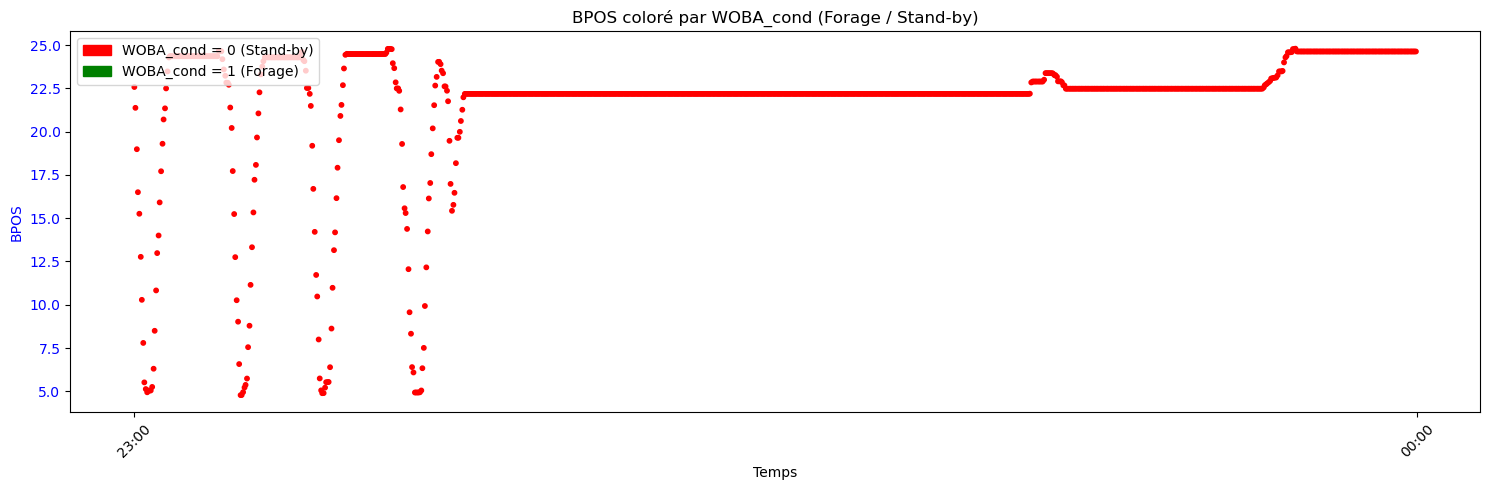

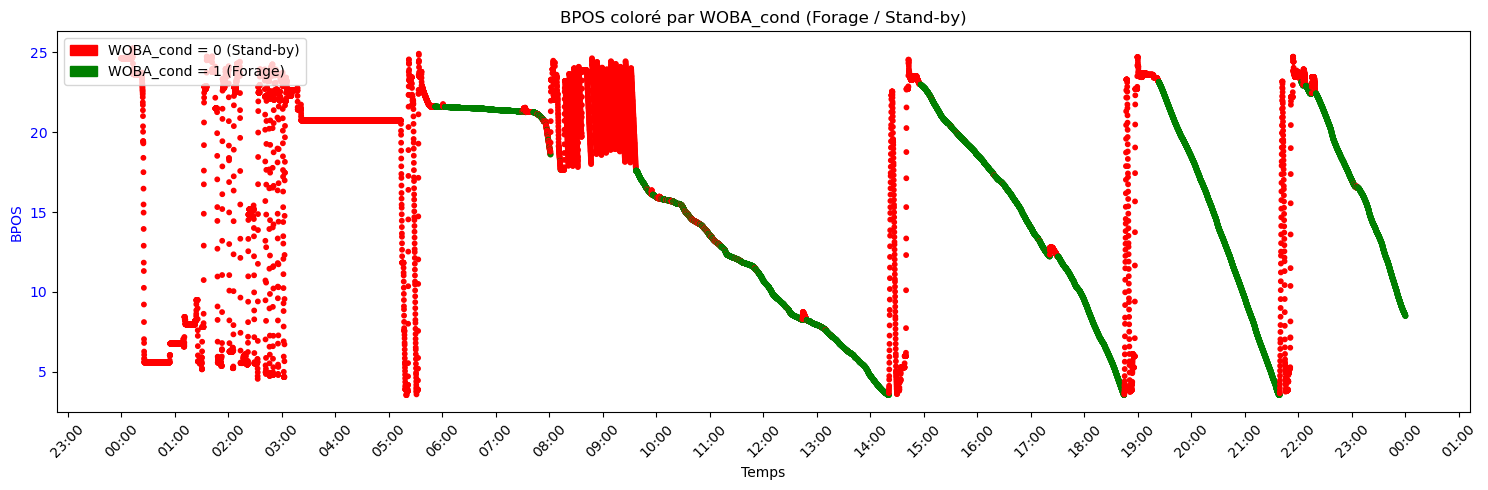

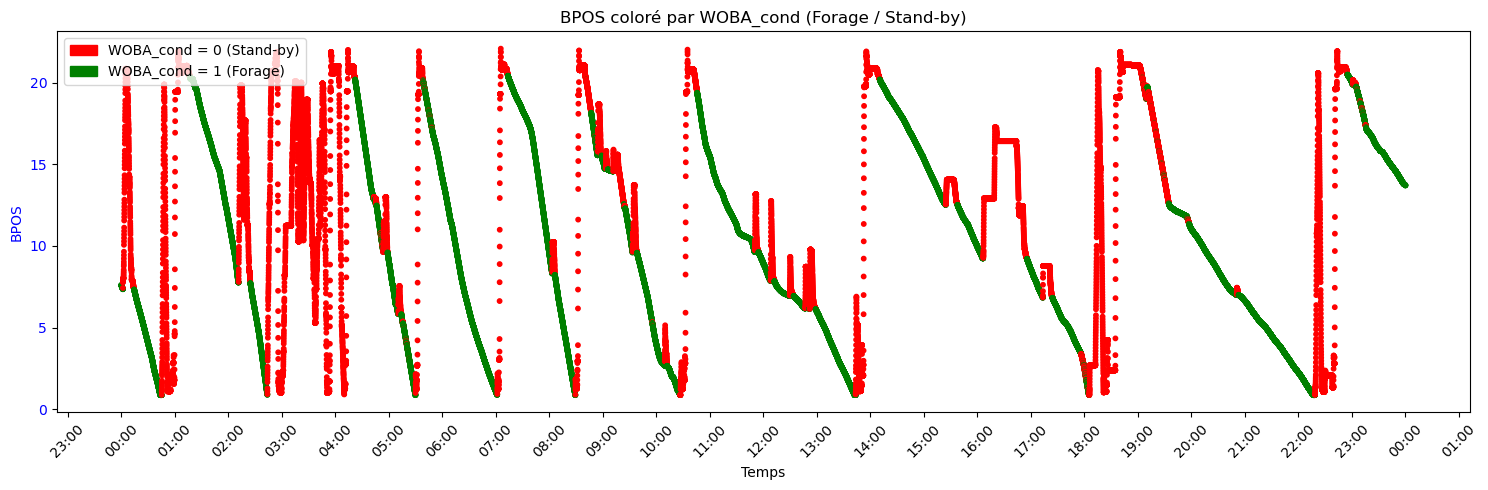

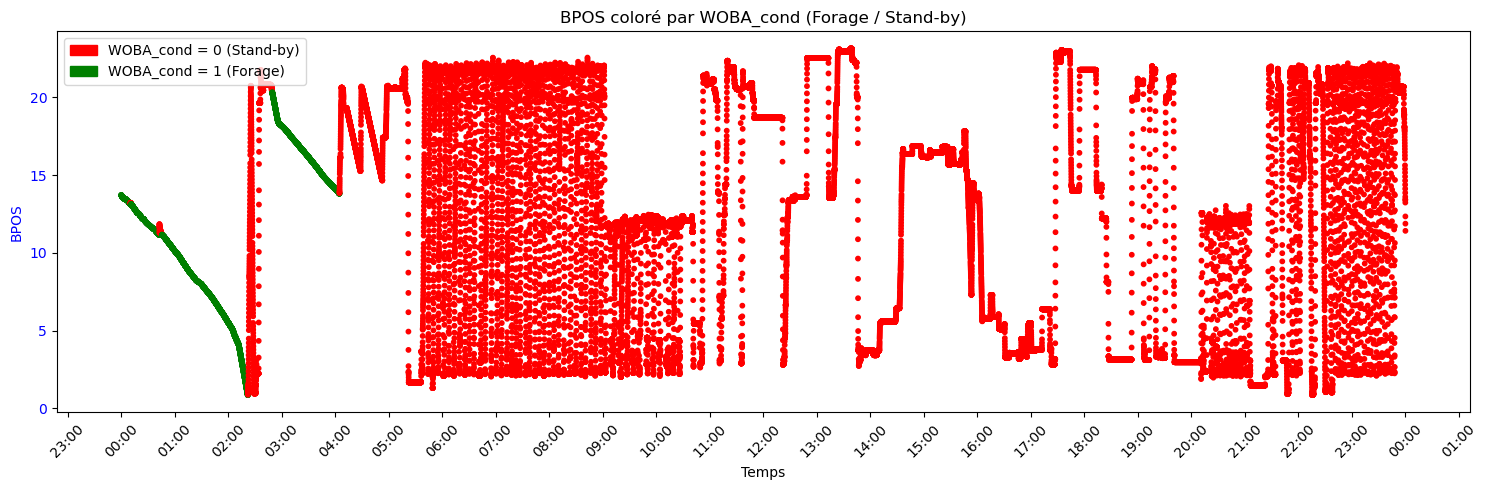

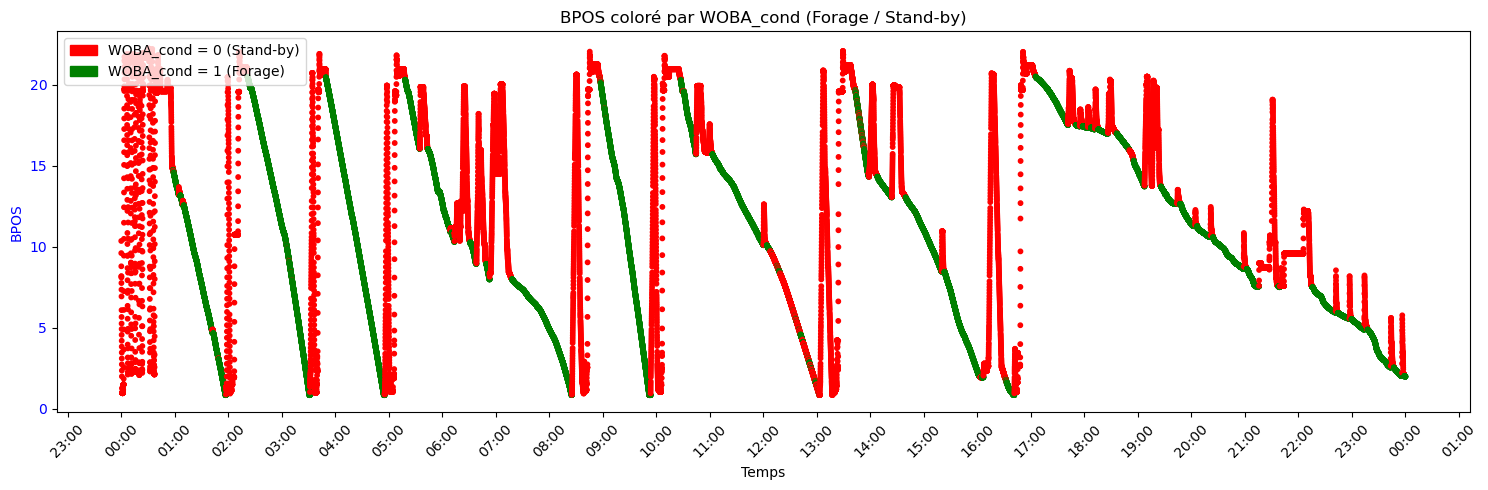

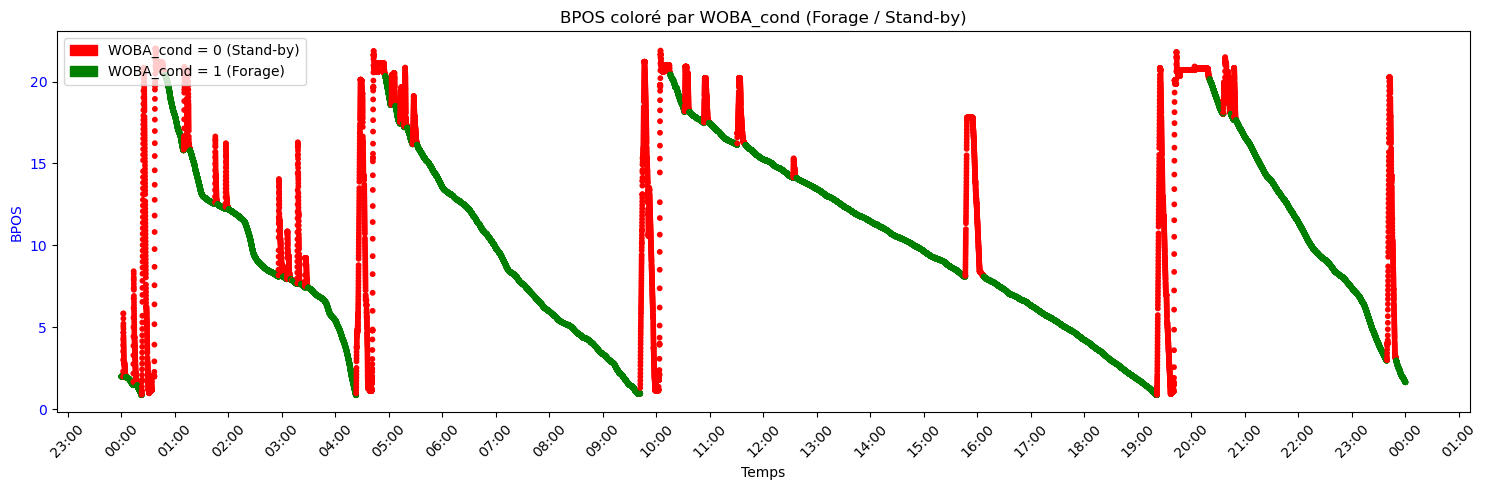

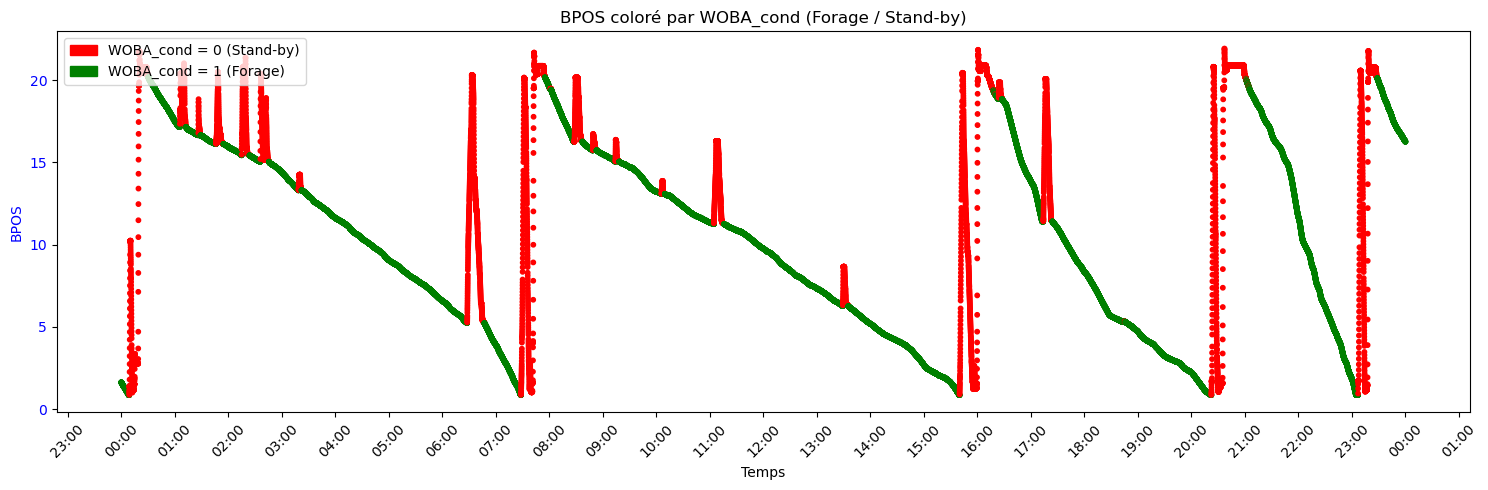

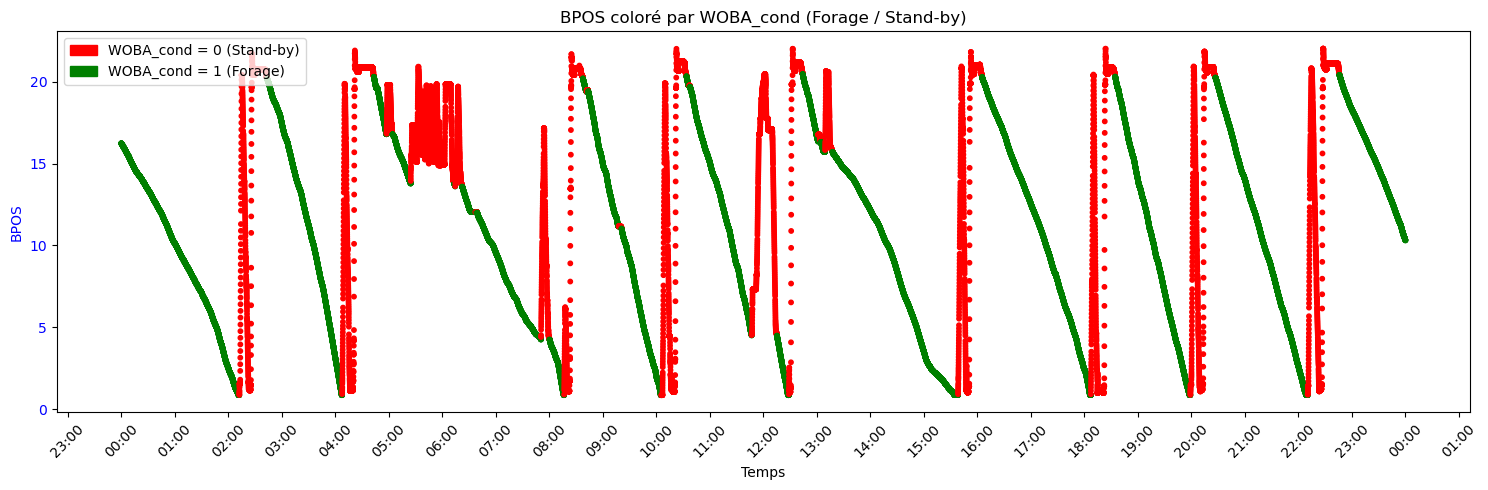

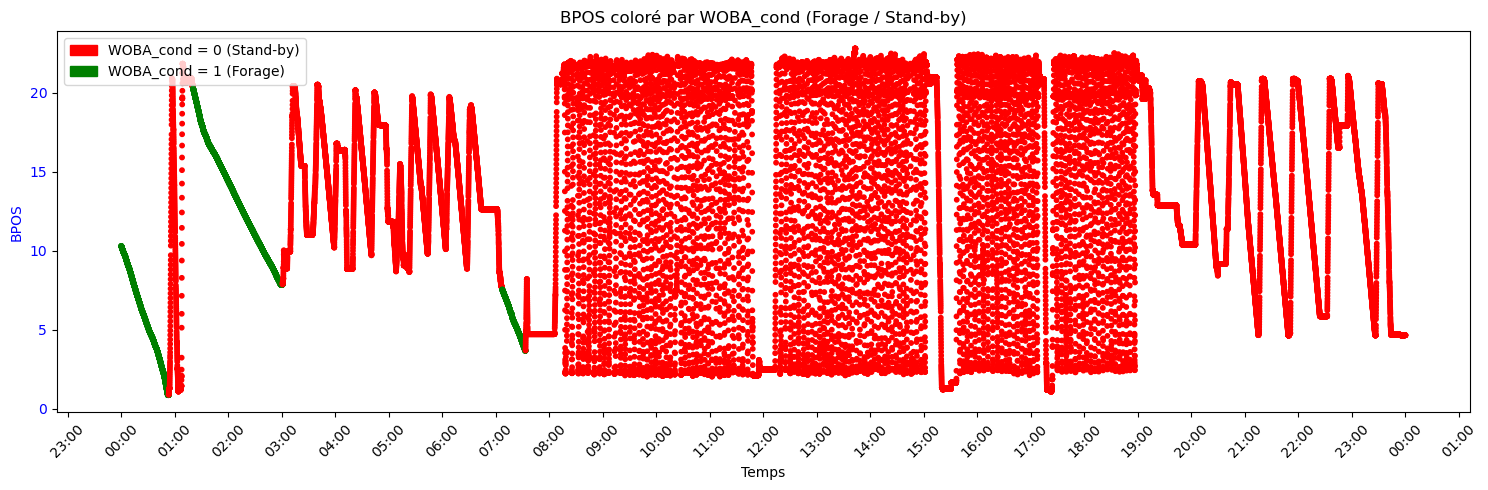

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Pour la gestion de la légende personnalisée
import matplotlib.dates as mdates  # Pour le formatage de l'axe X

# Fonction pour attribuer une couleur en fonction de 'WOBA_cond'
def get_color(WOBA_cond_value):
    color_map = {
        0: 'red',    # Si WOBA_cond == 0 -> Stand-by
        1: 'green',  # Si WOBA_cond == 1 -> Forage
    }
    return color_map.get(WOBA_cond_value, 'black')  # Retourne noir par défaut si pas trouvé

# Boucle pour chaque DataFrame dans processed_data
for df in processed_data:
    df.reset_index(inplace=True)  # Réinitialiser l'index sans ajouter l'index comme colonne

    fig, ax = plt.subplots(figsize=(15, 5))  # Créer une nouvelle figure et axe pour le graphique

    # Tracer BPOS coloré par WOBA_cond
    colors_bpos = df['WOBA_cond'].apply(get_color)  # Assigner les couleurs à chaque point en fonction de 'WOBA_cond'
    scatter_bpos = ax.scatter(df['TIME'], df['BPOS'], c=colors_bpos, label='BPOS = Position trépan', marker='o', s=10)

    ax.set_xlabel('Temps')
    ax.set_ylabel('BPOS', color='b')
    ax.tick_params(axis='y', labelcolor='b')

    # Créer la légende personnalisée pour WOBA_cond
    color_map = {
        0: 'red',    # WOBA_cond == 0 (Stand-by)
        1: 'green',  # WOBA_cond == 1 (Forage)
    }

    # Créer des éléments de légende pour chaque valeur de WOBA_cond
    legend_labels = [mpatches.Patch(color=color_map[key], label=f'WOBA_cond = {key} ({"Forage" if key == 1 else "Stand-by"})') for key in color_map]

    # Ajouter la légende pour WOBA_cond
    ax.legend(handles=legend_labels, loc='upper left')

    # Formatage de l'axe X pour afficher les heures
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Définit les ticks toutes les heures
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure : Heure:Minute
    plt.xticks(rotation=45)  # Rotation des labels de l'axe X pour lisibilité

    # Ajouter un titre
    plt.title('BPOS coloré par WOBA_cond (Forage / Stand-by)')

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


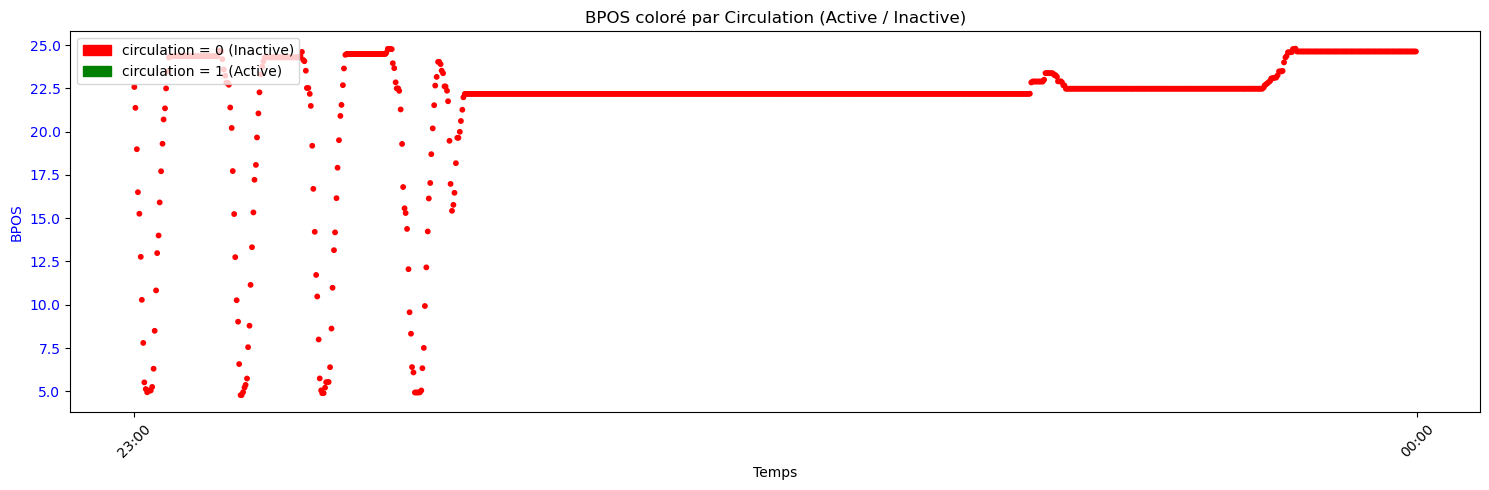

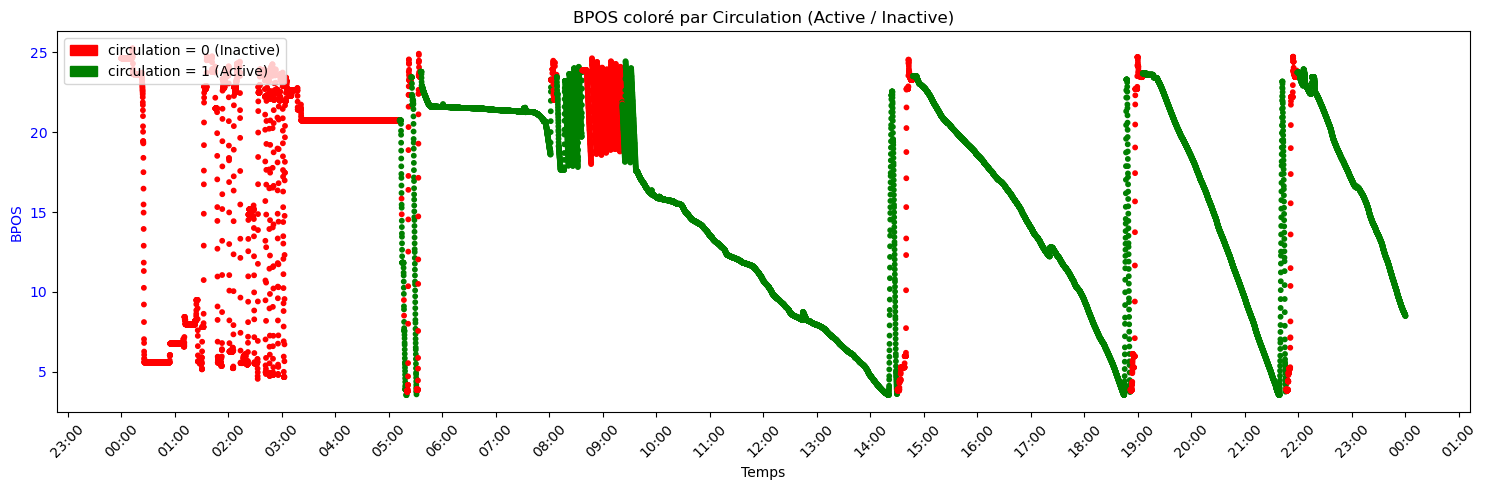

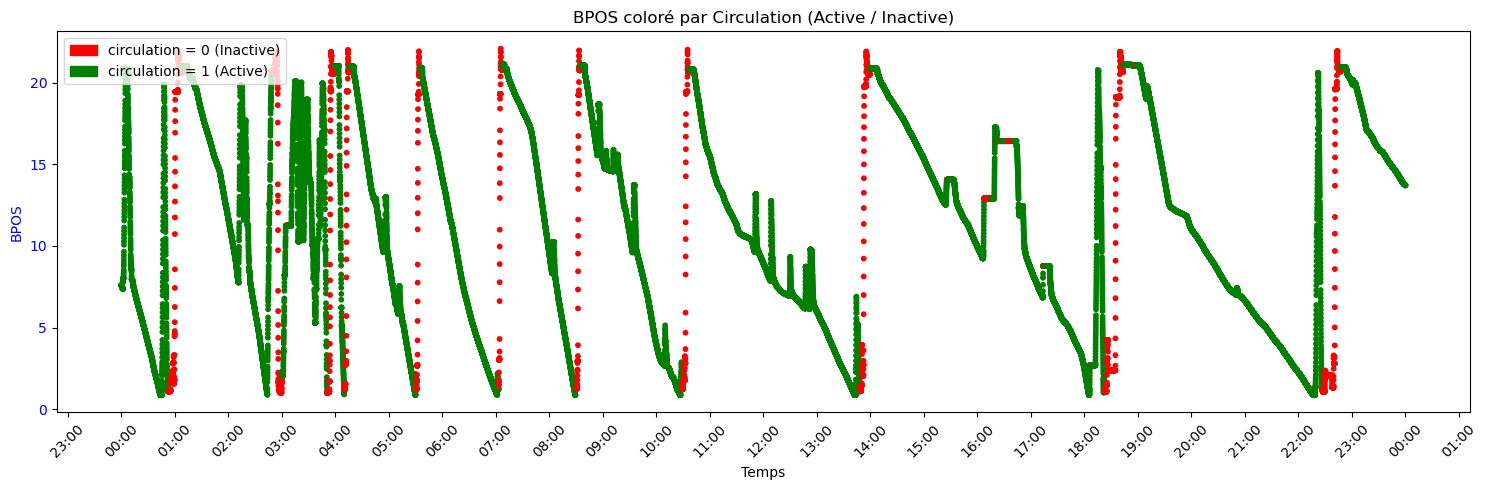

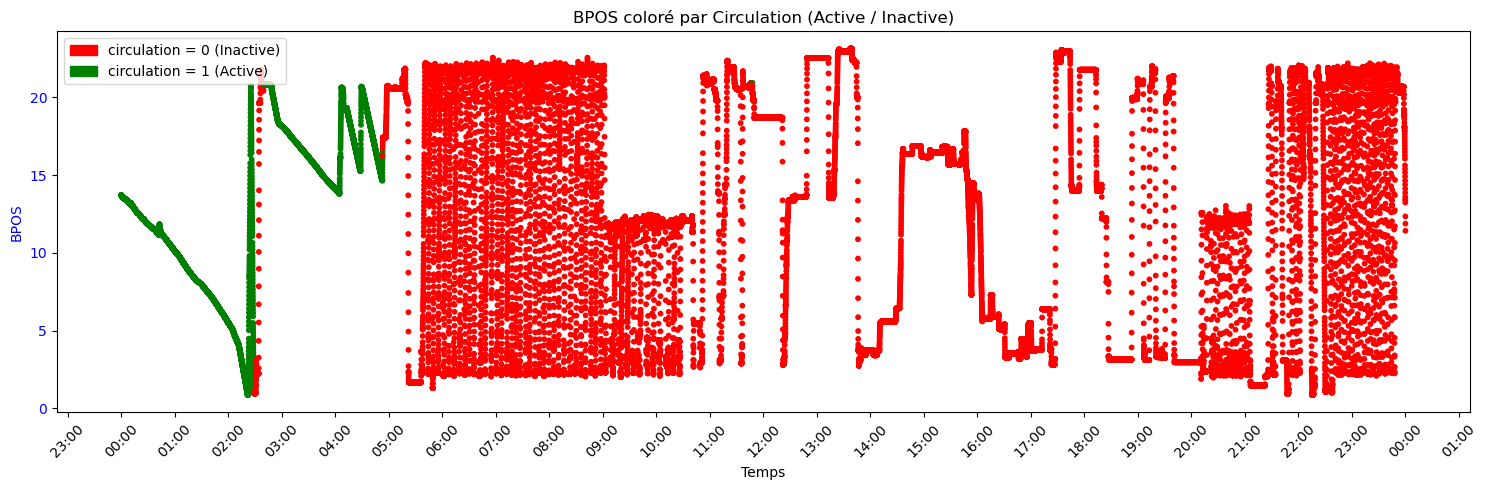

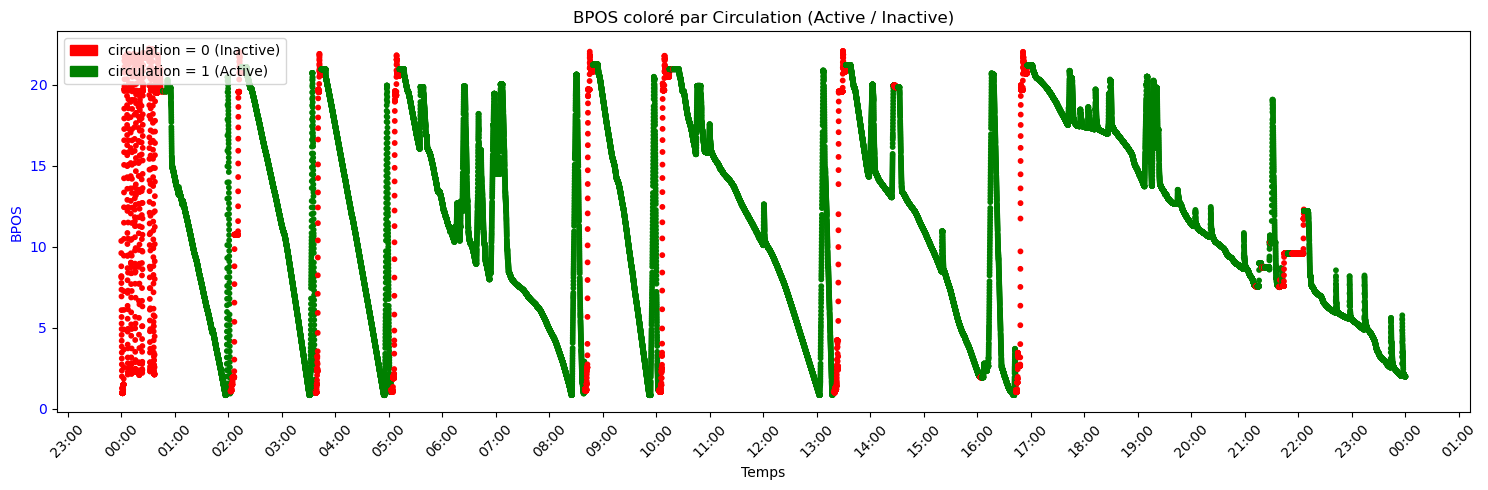

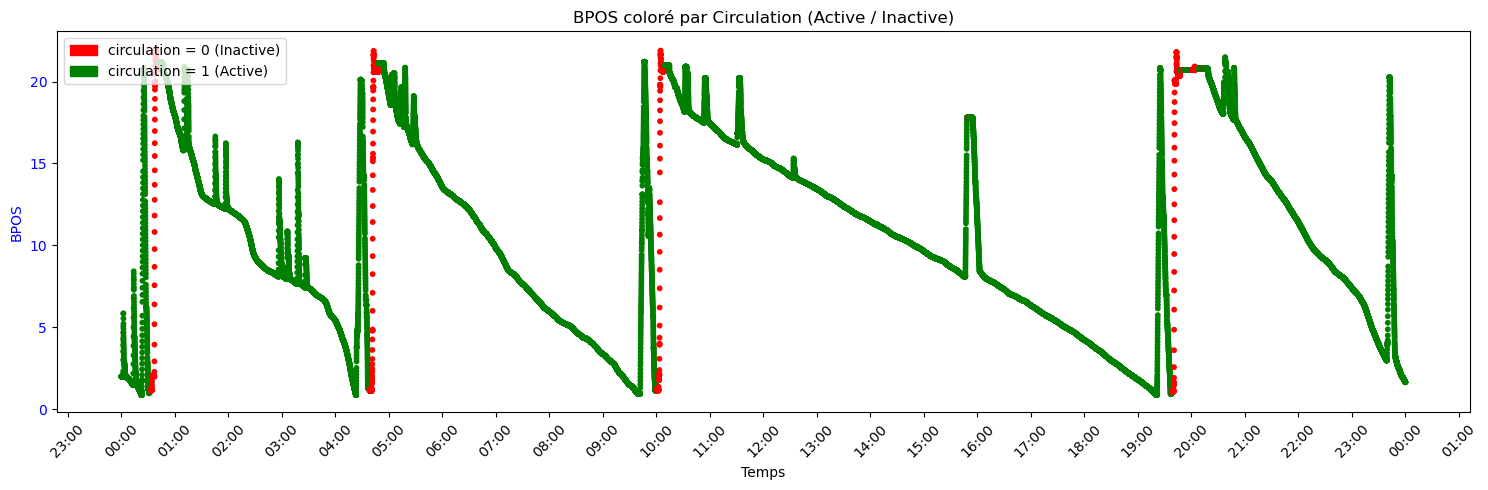

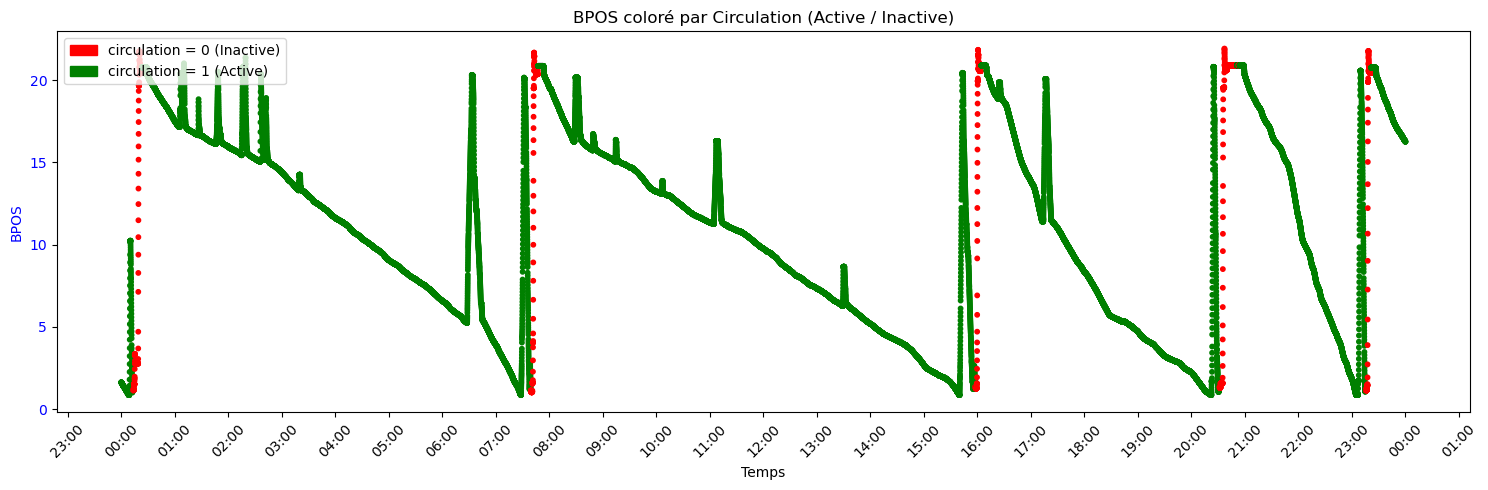

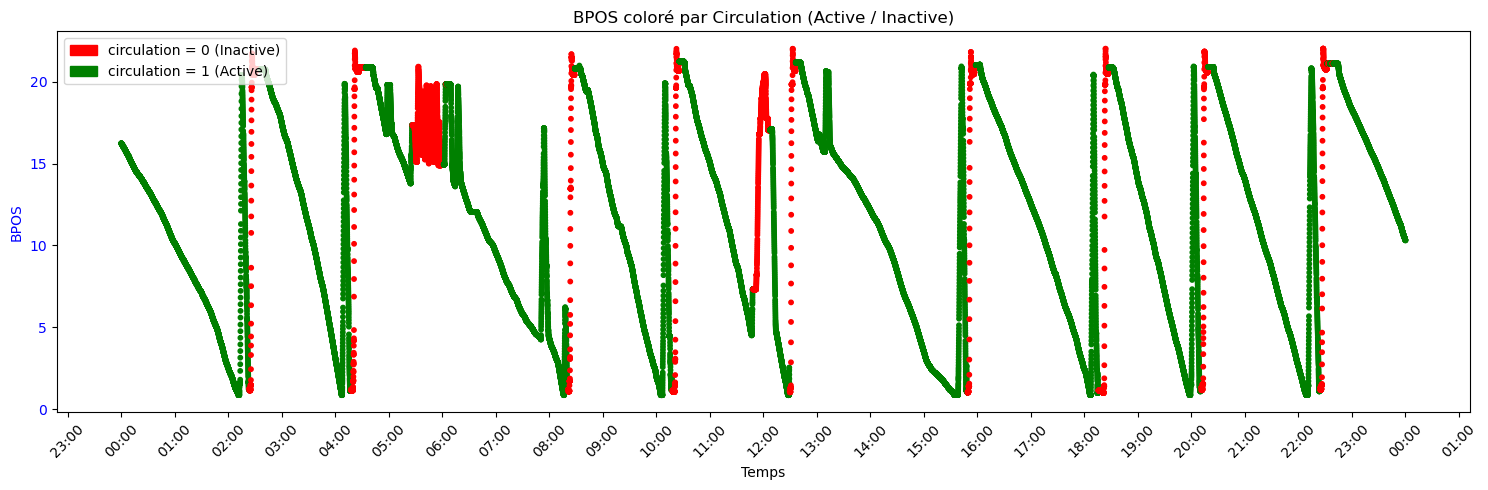

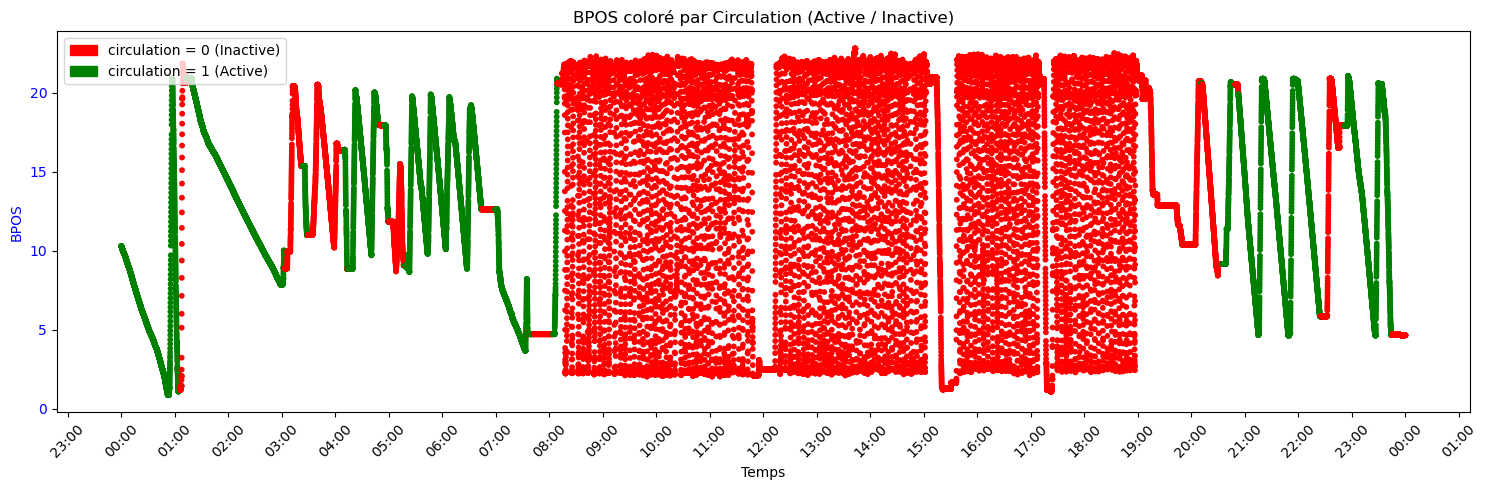

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches  # Pour la gestion de la légende personnalisée
import matplotlib.dates as mdates  # Pour le formatage de l'axe X

# Fonction pour attribuer une couleur en fonction de 'circulation'
def get_color_circulation(circulation_value):
    color_map = {
        0: 'red',    # Si circulation == 0 -> Pas de circulation
        1: 'green',  # Si circulation == 1 -> Circulation active
    }
    return color_map.get(circulation_value, 'black')  # Retourne noir par défaut si pas trouvé

# Boucle pour chaque DataFrame dans processed_data
for df in processed_data:
    df.reset_index(inplace=True)  # Réinitialiser l'index sans ajouter l'index comme colonne

    fig, ax = plt.subplots(figsize=(15, 5))  # Créer une nouvelle figure et axe pour le graphique

    # Tracer BPOS coloré par circulation
    colors_bpos = df['circulation'].apply(get_color_circulation)  # Assigner les couleurs à chaque point en fonction de 'circulation'
    scatter_bpos = ax.scatter(df['TIME'], df['BPOS'], c=colors_bpos, label='BPOS = Position trépan', marker='o', s=10)

    ax.set_xlabel('Temps')
    ax.set_ylabel('BPOS', color='b')
    ax.tick_params(axis='y', labelcolor='b')

    # Créer la légende personnalisée pour circulation
    color_map = {
        0: 'red',    # circulation == 0 (Pas de circulation)
        1: 'green',  # circulation == 1 (Circulation active)
    }

    # Créer des éléments de légende pour chaque valeur de circulation
    legend_labels = [mpatches.Patch(color=color_map[key], label=f'circulation = {key} ({ "Active" if key == 1 else "Inactive"})') for key in color_map]

    # Ajouter la légende pour circulation
    ax.legend(handles=legend_labels, loc='upper left')

    # Formatage de l'axe X pour afficher les heures
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Définit les ticks toutes les heures
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Format de l'heure : Heure:Minute
    plt.xticks(rotation=45)  # Rotation des labels de l'axe X pour lisibilité

    # Ajouter un titre
    plt.title('BPOS coloré par Circulation (Active / Inactive)')

    # Afficher le graphique
    plt.tight_layout()
    plt.show()
